In [1]:
import pandas as pd

df = pd.read_csv('creditcard.csv')

print(df.head())
print(df.describe())
print(df.info())

# Check for missing data
print("Null Values", df.isnull().sum())

# Check for duplicates
print("Duplicate Values", df.duplicated().sum())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [2]:
df = df.drop_duplicates()
df = df.dropna()
data_normalized = (df - df.mean()) / df.std()

In [3]:
#shape of data
print(data_normalized.shape)


(31650, 31)


In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
        super(TransformerAutoencoder, self).__init__()

        assert input_dim % num_heads == 0, "input_dim must be divisible by num_heads"

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=input_dim, nhead=num_heads)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded, encoded)  # Using encoded output as memory
        reconstructed = self.linear(decoded)
        return reconstructed

# Model parameters
input_dim = 31
hidden_dim = 64
num_layers = 2
num_heads = 1
num_epochs = 5
batch_size = 8

# Initialize model
model = TransformerAutoencoder(input_dim, hidden_dim, num_layers, num_heads)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data preparation
data_normalized_tensor = torch.tensor(data_normalized.values, dtype=torch.float32)
data_loader = DataLoader(data_normalized_tensor, batch_size=batch_size, shuffle=True)

# Lists to store results
epoch_losses = []

# Training loop
for epoch in range(num_epochs):
    batch_losses = []
    for batch in data_loader:
        optimizer.zero_grad()
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_loss = sum(batch_losses) / len(batch_losses)
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Average Loss: 0.4298
Epoch [2/5], Average Loss: 0.2614
Epoch [3/5], Average Loss: 0.2135
Epoch [4/5], Average Loss: 0.1969
Epoch [5/5], Average Loss: 0.1708


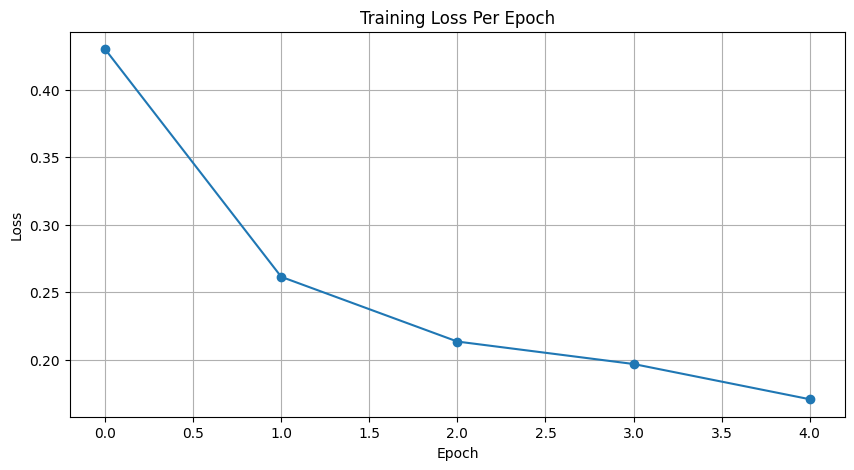

In [5]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, marker='o', linestyle='-')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Optionally save the model
torch.save(model.state_dict(), 'transformer_autoencoder.pth')


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Generator (using the saved TransformerAutoencoder model)
class Generator(nn.Module):
    def __init__(self, autoencoder_model):
        super(Generator, self).__init__()
        # Use the saved TransformerAutoencoder model as the generator
        self.autoencoder = autoencoder_model

    def forward(self, x):
        # Generator generates new data instances
        return self.autoencoder(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Adjust input_dim accordingly
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  # Outputting a single value representing the probability of being real
        return x

# Model parameters
input_dim = 31
# Instantiate the Generator
generator = Generator(model)

# Instantiate the Discriminator
discriminator = Discriminator(input_dim)

# Loss function and optimizer for the discriminator
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function and optimizer for the generator (optional)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)



In [17]:
import torch

def generate_geometric_mask(batch_size, length, p):
    """
    Generate a mask for a batch of data with a geometric distribution.

    Args:
        batch_size (int): Number of samples in the batch.
        length (int): Length of each sample.
        p (float): Probability parameter for the geometric distribution.

    Returns:
        torch.Tensor: A boolean tensor mask of shape [batch_size, length].
    """
    mask = torch.rand(batch_size, length) < p
    return mask.type(torch.bool)


def apply_mask(data, mask):
    masked_data = data.clone()
    masked_data[mask] = 0  # Masking
    return masked_data

class AugmentedDataLoader:
    def __init__(self, data, batch_size, p):
        self.data = data
        self.batch_size = batch_size
        self.p = p  # Probability for the geometric mask

    def __iter__(self):
        for i in range(0, len(self.data), self.batch_size):
            batch = self.data[i:i+self.batch_size]
            mask = generate_geometric_mask(batch.shape[1], self.p)
            masked_batch = apply_mask(batch, mask)
            yield masked_batch


In [ ]:
# Compute summary statistics
summary_statistics = data_normalized.describe()
print(summary_statistics)


               Time            V1            V2            V3            V4  \
count  2.837260e+05  2.837260e+05  2.837260e+05  2.837260e+05  2.837260e+05   
mean   2.436209e-16 -3.986889e-17 -4.808308e-18 -2.564431e-17  1.101904e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.996819e+00 -2.895928e+01 -4.415586e+01 -3.203273e+01 -4.016595e+00   
25%   -8.552113e-01 -4.732321e-01 -3.620482e-01 -5.907774e-01 -5.990509e-01   
50%   -2.131077e-01  7.426443e-03  4.134560e-02  1.182155e-01 -1.363451e-02   
75%    9.369406e-01  6.725529e-01  4.885020e-01  6.796309e-01  5.251179e-01   
max    1.642359e+00  1.257177e+00  1.339760e+01  6.217974e+00  1.193502e+01   

                 V5            V6            V7            V8            V9  \
count  2.837260e+05  2.837260e+05  2.837260e+05  2.837260e+05  2.837260e+05   
mean  -4.808308e-18  1.081869e-17 -2.163739e-17 -8.915405e-18 -1.404928e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.

In [ ]:
num_classes = len(data_normalized['Class'].unique())
print("Number of classes:", num_classes)


Number of classes: 2


In [20]:
import torch.nn as nn

class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
        super(TransformerAutoencoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=input_dim, nhead=num_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded, encoded)
        return self.linear(decoded)



import torch
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive



In [27]:
class Generator(nn.Module):
    def __init__(self, autoencoder_model):
        super(Generator, self).__init__()
        self.autoencoder = autoencoder_model

    def forward(self, x):
        return self.autoencoder(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim


# Initialize models and optimizers
model = TransformerAutoencoder(input_dim=31, hidden_dim=64, num_layers=2, num_heads=1)
generator = Generator(model)
hidden_size = 128

# Correct instantiation
discriminator = Discriminator(input_dim=31, hidden_size=hidden_size)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
ae_optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss functions
criterion_gan = nn.BCELoss()
contrastive_loss = ContrastiveLoss(margin=1.0)

# Training loop
for epoch in range(num_epochs):
    for data in data_loader:
        batch_size, sequence_length = data.shape
        # Generate masks and create masked data for contrastive learning
        mask = generate_geometric_mask(batch_size, sequence_length, p=0.1)
        positive_data = apply_mask(data, mask)
        negative_data = torch.roll(data, shifts=1, dims=0)  # Simple shift for negative sample

        # Train Discriminator
        real_output = discriminator(data)
        real_loss = criterion_gan(real_output, torch.ones_like(real_output))
        fake_data = generator(data)
        fake_output = discriminator(fake_data.detach())
        fake_loss = criterion_gan(fake_output, torch.zeros_like(fake_output))
        d_loss = real_loss + fake_loss
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        trick_output = discriminator(fake_data)
        g_loss = criterion_gan(trick_output, torch.ones_like(trick_output))
        g_loss.backward()
        g_optimizer.step()

        # Train Autoencoder with Contrastive Learning
        ae_optimizer.zero_grad()
        original_recon = model(data)
        positive_recon = model(positive_data)
        negative_recon = model(negative_data)
        pos_loss = contrastive_loss(original_recon, positive_recon, torch.ones(data.size(0), device=data.device))
        neg_loss = contrastive_loss(original_recon, negative_recon, torch.zeros(data.size(0), device=data.device))
        ae_loss = pos_loss + neg_loss
        ae_loss.backward()
        ae_optimizer.step()

        print(f'Epoch {epoch+1}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, AE Loss: {ae_loss.item():.4f}')


Streaming output truncated to the last 5000 lines.
Epoch 4, D Loss: 0.9982, G Loss: 1.6292, AE Loss: 0.7033
Epoch 4, D Loss: 0.5268, G Loss: 1.7000, AE Loss: 0.5052
Epoch 4, D Loss: 0.4603, G Loss: 1.4129, AE Loss: 0.5130
Epoch 4, D Loss: 0.7541, G Loss: 1.5758, AE Loss: 0.6669
Epoch 4, D Loss: 0.5205, G Loss: 1.6608, AE Loss: 0.5627
Epoch 4, D Loss: 0.7130, G Loss: 1.7125, AE Loss: 0.5269
Epoch 4, D Loss: 0.5742, G Loss: 1.6699, AE Loss: 0.5130
Epoch 4, D Loss: 1.1626, G Loss: 1.2517, AE Loss: 0.5692
Epoch 4, D Loss: 1.3161, G Loss: 1.2886, AE Loss: 0.5876
Epoch 4, D Loss: 0.9538, G Loss: 1.4277, AE Loss: 0.5821
Epoch 4, D Loss: 1.0373, G Loss: 1.3462, AE Loss: 0.5755
Epoch 4, D Loss: 0.5364, G Loss: 1.4665, AE Loss: 0.5600
Epoch 4, D Loss: 1.2515, G Loss: 1.3337, AE Loss: 0.5848
Epoch 4, D Loss: 0.7683, G Loss: 1.3861, AE Loss: 0.6506
Epoch 4, D Loss: 0.6028, G Loss: 1.3505, AE Loss: 0.6194
Epoch 4, D Loss: 0.7612, G Loss: 1.4590, AE Loss: 0.4910
Epoch 4, D Loss: 0.4479, G Loss: 1.35

In [31]:
import torch

def calculate_metrics(predicted, actual, threshold=0.1):
    # Calculate Mean Squared Error as a tensor
    mse = torch.mean((predicted - actual) ** 2)

    # Calculate Root Mean Squared Error
    rmse = torch.sqrt(mse)

    # Calculate Mean Absolute Error
    mae = torch.mean(torch.abs(predicted - actual))

    # Convert tensor results to floats for output
    mse = mse.item()
    rmse = rmse.item()
    mae = mae.item()

    # Assuming binary classification for discriminator outputs, here's how you might calculate accuracy:
    # This assumes your outputs and actuals are already binarized; adjust accordingly if not
    correct_predictions = torch.abs(predicted - actual) <= threshold
    accuracy = torch.mean(correct_predictions.float()).item()

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "Accuracy": accuracy}



In [32]:
for epoch in range(num_epochs):
    predicted_all = []
    actual_all = []
    for data in data_loader:
        with torch.no_grad():
            predicted = model(data)  # Get predictions for the current batch
            actual = data  # Actual data for comparison
            predicted_all.append(predicted)
            actual_all.append(actual)

    # Convert lists to tensors for metric calculation
    predicted_tensor = torch.cat(predicted_all, 0)
    actual_tensor = torch.cat(actual_all, 0)

    # Calculate and print metrics at the end of the epoch
    metrics = calculate_metrics(predicted_tensor, actual_tensor)
    print(f"Epoch {epoch+1} Metrics:", metrics)


Epoch 1 Metrics: {'MSE': 1.6489779949188232, 'RMSE': 1.2841253280639648, 'MAE': 0.9480143189430237, 'Accuracy': 0.061066094785928726}
Epoch 2 Metrics: {'MSE': 1.6493687629699707, 'RMSE': 1.2842775583267212, 'MAE': 0.9481624960899353, 'Accuracy': 0.06144830211997032}
Epoch 3 Metrics: {'MSE': 1.6494364738464355, 'RMSE': 1.284303903579712, 'MAE': 0.9481639266014099, 'Accuracy': 0.06129541993141174}
Epoch 4 Metrics: {'MSE': 1.6495306491851807, 'RMSE': 1.284340500831604, 'MAE': 0.9482166171073914, 'Accuracy': 0.061633795499801636}
Epoch 5 Metrics: {'MSE': 1.6491713523864746, 'RMSE': 1.284200668334961, 'MAE': 0.9480957388877869, 'Accuracy': 0.06156652793288231}
